In [1]:
import pandas as pd
import numpy as np
import sqlite3
import pandasql
from pandasql import sqldf
import matplotlib.pyplot as plt
import sklearn

pysqldf = lambda q: sqldf(q, globals())

# q = """
# ;"""
# data_cleaned = pysqldf(q)
# data_cleaned

## Imports
importing all files


In [2]:
data1 = pd.read_csv("./data/202004-divvy-tripdata.csv")
data2 = pd.read_csv("./data/202005-divvy-tripdata.csv")
data3 = pd.read_csv("./data/202006-divvy-tripdata.csv")
data4 = pd.read_csv("./data/202007-divvy-tripdata.csv")
data5 = pd.read_csv("./data/202008-divvy-tripdata.csv")
data6 = pd.read_csv("./data/202009-divvy-tripdata.csv")
data7 = pd.read_csv("./data/202010-divvy-tripdata.csv")
data8 = pd.read_csv("./data/202011-divvy-tripdata.csv")
data9 = pd.read_csv("./data/202012-divvy-tripdata.csv")


In [3]:

data10 = pd.read_csv("./data/202101-divvy-tripdata.csv")
data11 = pd.read_csv("./data/202102-divvy-tripdata.csv")
data12 = pd.read_csv("./data/202103-divvy-tripdata.csv")
data13 = pd.read_csv("./data/202104-divvy-tripdata.csv")
data14 = pd.read_csv("./data/202105-divvy-tripdata.csv")
data15 = pd.read_csv("./data/202106-divvy-tripdata.csv")
data16 = pd.read_csv("./data/202107-divvy-tripdata.csv")
data17 = pd.read_csv("./data/202108-divvy-tripdata.csv")
data22 = pd.read_csv("./data/Divvy_Trips_2020_Q1.csv")


In [4]:

# data19 = pd.read_csv("./data/Divvy_Trips_2019_Q2")

# data18 = pd.read_csv("./data/Divvy_Trips_2019_Q1")

# data20 = pd.read_csv("./data/Divvy_Trips_2019_Q3.csv")
# data21 = pd.read_csv("./data/Divvy_Trips_2019_Q4.csv")


In [5]:
data_cleaned = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11, data12, data13, data14, data15, data16, data17, data22])
data_cleaned.sort_values(by='started_at', inplace=True)

# Casual vs Member Riders

- Differences between the 2 kinds of users
    - Who bikes more often?
    - Are there differences in the times they bike at? (time of day; day of week; month of year)
    - Are there differences in the rideable types?
    - Are there differences in duration?
    - Differences in Location?

## Basic EDA
Finding the distribution of each type and how often they use Cyclist.

In [19]:
# Number of customers in each group
data_desc = data_cleaned['member_casual'].describe()
# print(d['freq']/d['count'])

# Trip duration of each group
data_cleaned['duration'] = pd.to_datetime(data_cleaned['ended_at']) - pd.to_datetime(data_cleaned['started_at'])
data_cleaned['duration'] = data_cleaned['duration'].dt.seconds/3600
group_duration = data_cleaned.groupby('member_casual')['duration'].agg('sum')

# Trip number of each group
data_cleaned['trips'] = 1
trip_amt = data_cleaned.groupby('member_casual')['trips'].agg('sum')



In [33]:
groups = ['member', 'casual']

fig = plt.figure(figsize=(18,10), dpi=1600)

ax1 = plt.subplot2grid((1,3),(0,0))
plt.pie([data_desc['freq'], data_desc['count']], labels=groups, autopct='%1.2f%%')
plt.title('Number of members vs casual customers')
#next one
ax1 = plt.subplot2grid((1, 3), (0, 1))
plt.pie([float(group_duration['member']), float(group_duration['casual'])], labels=groups, autopct='%1.2f%%')
plt.title('Duration of trips for members vs casual')

ax1 = plt.subplot2grid((1, 3), (0, 2))
plt.pie([float(trip_amt['member']), float(trip_amt['casual'])], labels=groups, autopct='%1.2f%%')
plt.title('Number of trips for members vs casual')
plt.savefig('cyclist_pie.png', bbox_inches='tight')
# plt.show()


## Daily Distribution
How often does each customer type use Cyclist and at what times.

In [39]:
from sklearn import preprocessing
pd.options.mode.chained_assignment = None

store = [data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11, data12, data13, data14, data15, data16, data17]
months = ['April 2020', 'May 2020', 'June 2020', 'July 2020', 'August 2020', 'September 2020', 'October 2020', 'November 2020', 'December 2020', 'January 2021', 'February 2021', 'March 2021', 'April 2021', 'May 2021', 'June 2021', 'July 2021', 'August 2021']

def get_class_data(data1_times, name):
    member_data = data1_times[data1_times['member_casual'] == name]
    member_data.loc[:, 'hour'] = pd.to_datetime(member_data['started_at']).dt.hour
    member_data.loc[:, 'trips'] = 1
    member_data.loc[:, 'duration'] = member_data['duration'].dt.seconds/3600
    member_scatter = member_data.groupby(['hour'])['duration'].agg('sum')
    alphas = member_data.groupby(['hour'])['trips'].agg('sum')
    member_x = list(member_scatter.index)
    member_y = list(member_scatter.values)

    docked_bike = member_data[member_data['rideable_type'] == 'docked_bike']
    electric_bike =  member_data[member_data['rideable_type'] == 'electric_bike']
    classic_bike =  member_data[member_data['rideable_type'] == 'classic_bike']
    docked_hour = docked_bike.groupby(['hour'])['rideable_type'].agg('count')
    electric_hour = electric_bike.groupby(['hour'])['rideable_type'].agg('count')
    classic_hour = classic_bike.groupby(['hour'])['rideable_type'].agg('count')
    bike_df = pd.DataFrame({'docked': docked_hour, 'electric': electric_hour, 'classic': classic_hour})
    
    return member_x, member_y, alphas, bike_df

def create_versus_scatter(data, month, k):
    data_times = data.drop(data.columns[[4,5,6,7,8,9,10,11]], axis=1)
    data_times.loc[:, 'duration'] = pd.to_datetime(data_times['ended_at']) - pd.to_datetime(data_times['started_at'])

    member_x, member_y, alphas_m,  bike_df_m = get_class_data(data_times, 'member')
    casual_x, casual_y, alphas_c,  bike_df_c = get_class_data(data_times, 'casual')
    fig, ax = plt.subplots(1)
    ax.scatter(member_x, member_y, color='#BE4152', label='member')
    ax.scatter(casual_x, casual_y, color='teal', label='casual')
    ax.legend(loc='upper left')
    ax.set_ylabel('total duration in the bike (in hours)')
    ax.set_xlabel('hour of day')
    ax.set_title(f'Member vs Casual bike rides for {month}')
    plt.rcParams["figure.figsize"] = (12,3)
    ax.set_xticks(member_x)
    ax.set_xticklabels(x_labels, rotation=45)

    ax2=ax.twinx()
    ax2.plot(member_x, alphas_m, color='#BE4152', label='total trips by member')
    ax2.plot(member_x, alphas_c, color='teal', label='total trips by casual')
    

    if month not in ['April 2020', 'May 2020', 'June 2020', 'July 2020', 'August 2020']:
        ax2.scatter(member_x, bike_df_m['docked'], color='#BE4152', marker='v', label='trips in docked bike', alpha=0.5)
        ax2.scatter(member_x, bike_df_m['electric'], color='#BE4152', marker='s', label='trips in electric bike', alpha=0.5)
        ax2.scatter(member_x, bike_df_m['classic'], color='#BE4152', marker='+', label='trips in classic bike', alpha=0.5)

        ax2.scatter(member_x, bike_df_c['docked'], color='teal', marker='v', alpha=0.5)
        ax2.scatter(member_x, bike_df_c['electric'], color='teal', marker='s', alpha=0.5)
        ax2.scatter(member_x, bike_df_c['classic'], color='teal', marker='+', alpha=0.5)
        
    else:
        ax.text(0.05, 0.4, 'only docked bikes are used this month', transform=ax.transAxes, style='italic', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    ax2.legend(loc='upper right')
    ax2.set_ylabel("number of trips")
    plt.show()
    plt.savefig(f'cyclist_{k}.png')


x_labels = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am','11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']

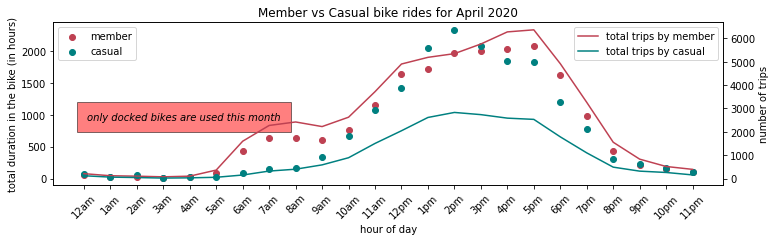

<Figure size 864x216 with 0 Axes>

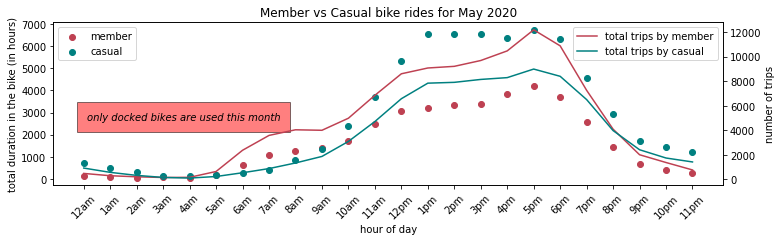

<Figure size 864x216 with 0 Axes>

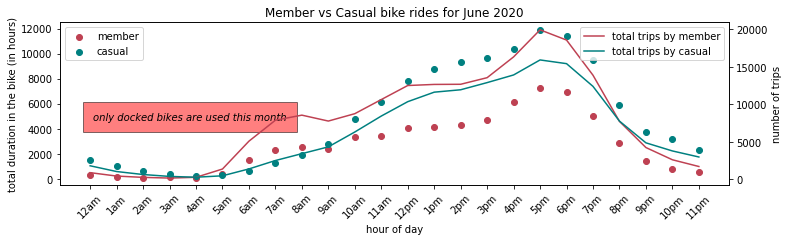

<Figure size 864x216 with 0 Axes>

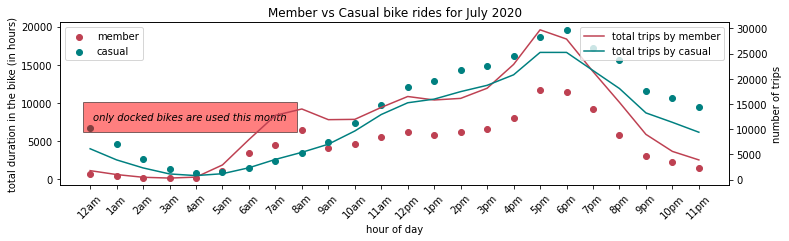

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

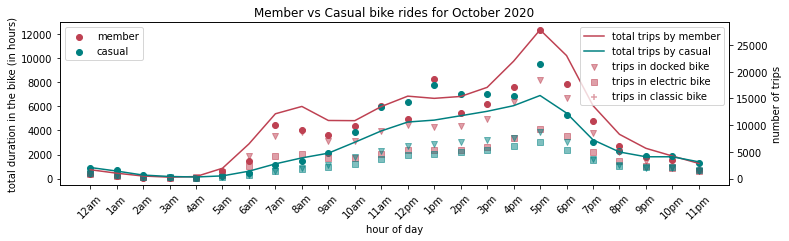

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

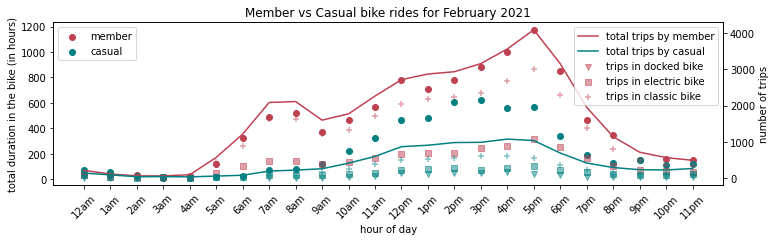

<Figure size 864x216 with 0 Axes>

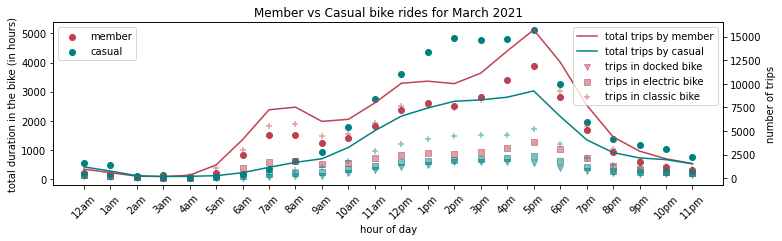

<Figure size 864x216 with 0 Axes>

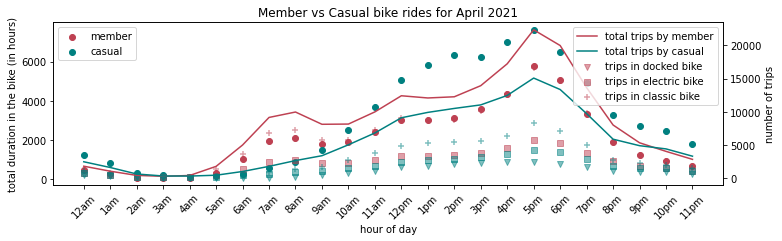

<Figure size 864x216 with 0 Axes>

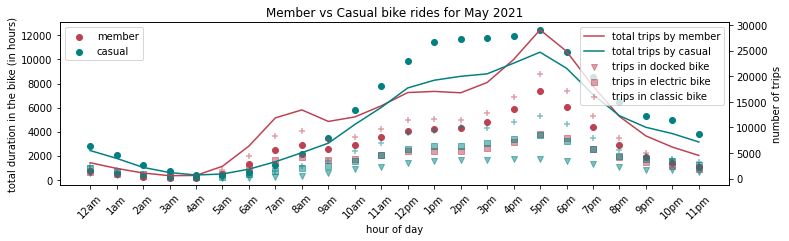

<Figure size 864x216 with 0 Axes>

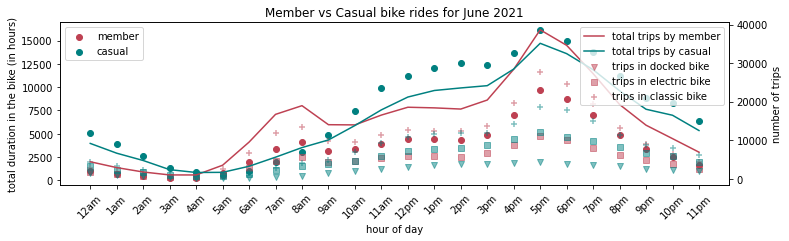

<Figure size 864x216 with 0 Axes>

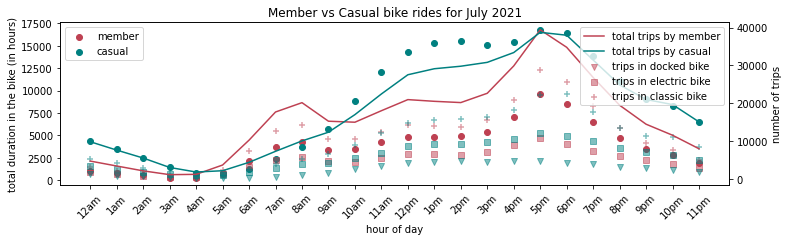

<Figure size 864x216 with 0 Axes>

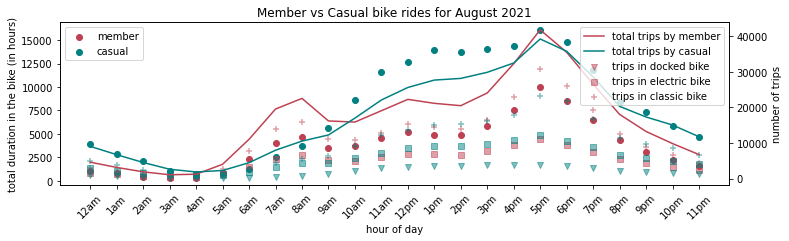

<Figure size 864x216 with 0 Axes>

In [41]:
for k, data in enumerate(store):
    create_versus_scatter(data, months[k], k)
    

## Comparing month-to-month data for riders
What times of the day do riders use Cyclist?

In [27]:
# split the days into 4 sections and apply on each month.
morning = [4, 5, 6, 7, 8, 9]
afternoon = [10, 11, 12, 13, 14, 15]
evening = [16, 17, 18, 19, 20, 21]
night = [22, 23, 0, 1, 2, 3]

In [28]:
def create_stacked_bar(data, month):
    data_times = data.drop(data.columns[[4,5,6,7,8,9,10,11]], axis=1)
    data_times['duration'] = pd.to_datetime(data_times['ended_at']) - pd.to_datetime(data_times['started_at'])
    data_times['duration'] = data_times['duration'].dt.seconds/3600
    data_times['hour'] = pd.to_datetime(data_times['started_at']).dt.hour
    data_times['hour'].loc[(data_times['hour'] >= 22) | (data_times['hour'] <= 3)] = 3
    data_times['hour'].loc[(data_times['hour'] >= 4) & (data_times['hour'] <= 9)] = 0
    data_times['hour'].loc[(data_times['hour'] >= 10) & (data_times['hour'] <= 15)] = 1
    data_times['hour'].loc[(data_times['hour'] >= 16) & (data_times['hour'] <= 21)] = 2
    y = pd.DataFrame(data_times.groupby('hour')['duration'].agg(sum))
    y.index = ['morning', 'afternoon', 'evening', 'night']
    y = y.T
    y.index = [month]
    return y

def create_bar_df(data, name, y, index):
    split_dat = split_data(data, name)
    y = y.append(create_stacked_bar(split_dat, months[index]))
    return y

def split_data(data, name):
    member_data = data[data['member_casual'] == name]
    return member_data



# member data:
member_bar_df = pd.DataFrame()
for k, i in enumerate(store):
    member_bar_df = create_bar_df(i, 'member', member_bar_df, k)

# casual data:
casual_bar_df = pd.DataFrame()
for k, i in enumerate(store):
    casual_bar_df = create_bar_df(i, 'casual', casual_bar_df, k)


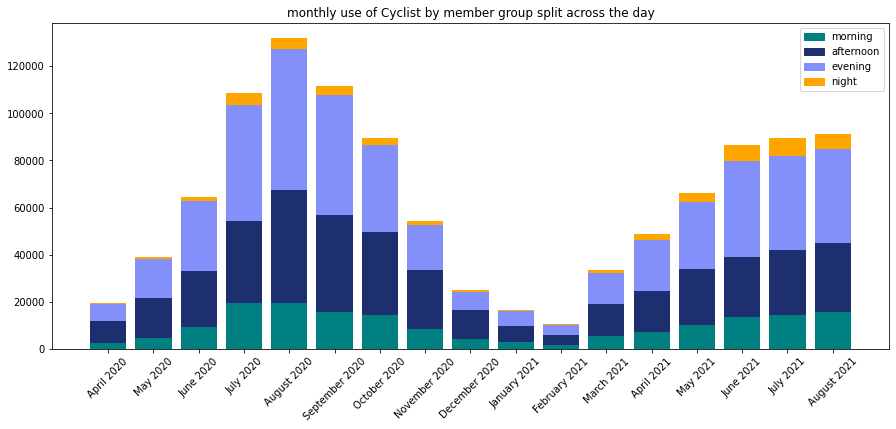

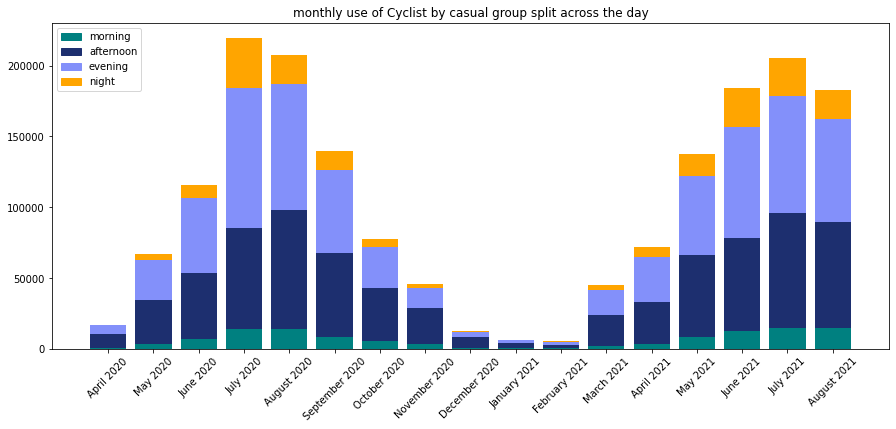

In [29]:
import matplotlib.patches as mpatches

def plot_bar_chart(y, group_name):
    fields = ['morning','afternoon', 'evening', 'night']
    colors = [ 'teal', '#1D2F6F', '#8390FA', 'orange']

    fig, ax = plt.subplots(1, figsize=(15, 6))
    left = len(y) * [0]
    for idx, name in enumerate(fields):
        plt.bar(y.index, y[name], bottom = left, color=colors[idx])
        left = left + y[name]

    morn = mpatches.Patch(color='teal', label='morning')
    aft = mpatches.Patch(color='#1D2F6F', label='afternoon')
    eve = mpatches.Patch(color='#8390FA', label='evening')
    night = mpatches.Patch(color='orange', label='night')

    plt.legend(handles=[morn, aft,eve, night ])
    plt.title(f"monthly use of Cyclist by {group_name} group split across the day")
    plt.xticks(rotation=45)

plot_bar_chart(member_bar_df, 'member')
plot_bar_chart(casual_bar_df, 'casual')

## Further Analysis
New EDA -- Rideable Type

In [30]:
data6['rideable_type'].value_counts()

docked_bike      404606
electric_bike    128352
Name: rideable_type, dtype: int64

# Comments

- Seasonal Use
    - Bikes are used more often during the summers so price change
- Daily use
    - During the day, bikes are used more often during 12pm - 6pm. Change Price Accordingly
    - The members have more trips while the casual users have more duration spent each trip. If you start having weekly/monthly passes for casual members, you could try to move them into an annual user gradually
- Bike Type 
    - Change


In [9]:
# Network


from pyvis.network import Network
net = Network()

In [13]:
network_df = data_cleaned[['start_station_', 'end_station_name']].copy()

ride_id  rideable_type           started_at  \
99279   1068AB1B8F12FE23    docked_bike  2020-01-01 00:04:44   
143776  DCF74A0EB3284B3E    docked_bike  2020-01-01 00:10:37   
143777  4DE50A4FC7687A0D    docked_bike  2020-01-01 00:11:14   
39811   1C78B5F337CBFC93    docked_bike  2020-01-01 00:11:27   
94468   D231CE7990A3AA52    docked_bike  2020-01-01 00:12:34   
...                  ...            ...                  ...   
434919  5DFCC9B26EA436B6  electric_bike  2021-08-31 23:59:02   
603833  696964CAEBC45937  electric_bike  2021-08-31 23:59:04   
4311    448D1DCC9301FCF8  electric_bike  2021-08-31 23:59:04   
750467  99571F638261030D   classic_bike  2021-08-31 23:59:09   
122688  07B5978B18B81768   classic_bike  2021-08-31 23:59:35   

                   ended_at              start_station_name start_station_id  \
99279   2020-01-01 00:17:08  Sheffield Ave & Wellington Ave              115   
143776  2020-01-01 00:10:54              Daley Center Plaza               81   
143777  2020-01-01 00:15:32              Daley Center Plaza               81   
39811   2020-01-01 00:13:15    Sheridan Rd & Irving Park Rd              240   
94468   2020-01-01 00:14:29        Delano Ct & Roosevelt Rd              626   
...                     ...                             ...              ...   
434919  2021-09-01 00:01:24               Wells St & Elm St     KA1504000135   
603833  2021-09-01 00:02:16           Clark St & Berwyn Ave     KA1504000146   
4311    2021-09-01 00:03:36                             NaN              NaN   
750467  2021-09-01 00:03:05       Lincoln Ave & Belmont Ave     TA1309000042   
122688  2021-09-01 00:03:09            Canal St & Taylor St            15550   

                      end_station_name end_station_id  start_lat  start_lng  \
99279   Ashland Ave & Belle Plaine Ave          246.0  41.936300 -87.652700   
143776              Daley Center Plaza           81.0  41.884200 -87.629600   
143777      Dearborn St & Van Buren St          624.0  41.884200 -87.629600   
39811           Broadway & Sheridan Rd          256.0  41.954200 -87.654400   
94468        Wabash Ave & Roosevelt Rd           59.0  41.867500 -87.632200   
...                                ...            ...        ...        ...   
434919     Dearborn Pkwy & Delaware Pl   TA1307000128  41.902993 -87.634214   
603833                             NaN            NaN  41.977997 -87.668037   
4311                               NaN            NaN  41.910000 -87.760000   
750467     Lincoln Ave & Diversey Pkwy   TA1307000064  41.939365 -87.668385   
122688         Canal St & Jackson Blvd          13138  41.870257 -87.639474   

          end_lat    end_lng member_casual  
99279   41.956100 -87.668800        casual  
143776  41.884200 -87.629600        member  
143777  41.876300 -87.629200        member  
39811   41.952800 -87.650000        member  
94468   41.867200 -87.626000        member  
...           ...        ...           ...  
434919  41.898995 -87.630102        member  
603833  41.990000 -87.670000        member  
4311    41.910000 -87.760000        casual  
750467  41.932225 -87.658617        member  
122688  41.877245 -87.639366        member  

[7141855 rows x 13 columns]

In [14]:
network_df

start_station_name                end_station_name
99279   Sheffield Ave & Wellington Ave  Ashland Ave & Belle Plaine Ave
143776              Daley Center Plaza              Daley Center Plaza
143777              Daley Center Plaza      Dearborn St & Van Buren St
39811     Sheridan Rd & Irving Park Rd          Broadway & Sheridan Rd
94468         Delano Ct & Roosevelt Rd       Wabash Ave & Roosevelt Rd
...                                ...                             ...
434919               Wells St & Elm St     Dearborn Pkwy & Delaware Pl
603833           Clark St & Berwyn Ave                             NaN
4311                               NaN                             NaN
750467       Lincoln Ave & Belmont Ave     Lincoln Ave & Diversey Pkwy
122688            Canal St & Taylor St         Canal St & Jackson Blvd

[7141855 rows x 2 columns]

In [26]:
import pandas as pd
import numpy as np
import networkx as nx
r = np.random.RandomState(seed=5)
ints = r.random_integers(1, 10, size=(3,2))
a = ['A', 'B', 'C']
b = ['D', 'A', 'E']
df = pd.DataFrame(ints, columns=['weight', 'cost'])
df[0] = a
df['b'] = b
df
G=nx.from_pandas_edgelist(df, 0, 'b', ['weight', 'cost'])
G['E']['C']['weight']
G['E']['C']['cost']

<ipython-input-26-7f58a9929306>:5: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  ints = r.random_integers(1, 10, size=(3,2))


9

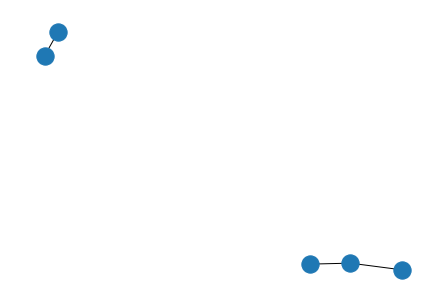

In [27]:
nx.draw(G)

In [ ]:
def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=False,only_physics_buttons=False):
        """
        This function accepts a networkx graph object,
        converts it to a pyvis network object preserving its node and edge attributes,
        and both returns and saves a dynamic network visualization.

        Valid node attributes include:
            "size", "value", "title", "x", "y", "label", "color".

            (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)

        Valid edge attributes include:
            "arrowStrikethrough", "hidden", "physics", "title", "value", "width"

            (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)


        Args:
            networkx_graph: The graph to convert and display
            notebook: Display in Jupyter?
            output_filename: Where to save the converted network
            show_buttons: Show buttons in saved version of network?
            only_physics_buttons: Show only buttons controlling physics of network?
        """

        # import
        from pyvis import network as net

        # make a pyvis network
        pyvis_graph = net.Network(notebook=notebook)
        pyvis_graph.width = '1000px'
        # for each node and its attributes in the networkx graph
        for node,node_attrs in networkx_graph.nodes(data=True):
            pyvis_graph.add_node(node,**node_attrs)
    #         print(node,node_attrs)

        # for each edge and its attributes in the networkx graph
        for source,target,edge_attrs in networkx_graph.edges(data=True):
            # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
            if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
                # place at key 'value' the weight of the edge
                edge_attrs['value']=edge_attrs['weight']
            # add the edge
            pyvis_graph.add_edge(source,target,**edge_attrs)

        # turn buttons on
        if show_buttons:
            if only_physics_buttons:
                pyvis_graph.show_buttons(filter_=['physics'])
            else:
                pyvis_graph.show_buttons()

        # return and also save
        return pyvis_graph.show(output_filename)